In [1]:
import numpy as np
import scipy.signal as signal
import nibabel as nb
%pylab inline
import time
def detrend_common(y, order=1, axis=-1):
    #https://stackoverflow.com/questions/8355197/detrending-a-time-series-of-a-multi-dimensional-array-without-the-for-loops
    '''detrend multivariate series by common trend

    Paramters
    ---------
    y : ndarray
       data, can be 1d or nd. if ndim is greater then 1, then observations
       are along zero axis
    order : int
       degree of polynomial trend, 1 is linear, 0 is constant

    Returns
    -------
    y_detrended : ndarray
       detrended data in same shape as original 

    '''
    nobs = y.shape[axis]
    shape = y.shape
    y_ = y.ravel()
    nobs_ = len(y_)
    t = np.repeat(np.arange(nobs), nobs_ /float(nobs))
    exog = np.vander(t, order+1)
    params = np.linalg.lstsq(exog, y_) 
    fittedvalues = np.dot(exog, params[0])
    resid = (y_ - fittedvalues).reshape(*shape)
    return resid, params

Populating the interactive namespace from numpy and matplotlib


In [19]:
img = nb.load('BP4T_rest1_1_denoised.nii.gz')
d = img.get_data()
aff = img.affine
head = img.header

In [20]:
d_vol = d[...,0]
z_mask = d_vol.astype(bool)
data_masked = d[z_mask[...,:]]

In [21]:
#take signal
#create new signal that is the sum of all signal to time t

order = 2
data_masked_cumsum = np.cumsum(data_masked,axis=1) #cumsum over time
#window this shit
t_pts = data_masked_cumsum.shape[1]
window_nums = np.floor(np.linspace(np.floor(t_pts/(t_pts/5)).astype(int),np.floor(t_pts/5).astype(int),num=8)[::-1]) #reverse, so we go from smaller num samples up
#window_nums = np.array([5,10,20,30])
print("Number of windows per iteration:")
print(window_nums)
N_var_mat = np.zeros((data_masked_cumsum.shape[0],len(window_nums)))

for win_idx,window_num in enumerate(window_nums):
    st=time.time()
    wins=np.array_split(data_masked_cumsum,window_num,axis=1)
    var = np.zeros((data_masked_cumsum.shape[0],len(wins)))
    for idx,win in enumerate(wins):
        #calc variance for detrended window data
        #detrend all windows
        var[:,idx]= np.std(detrend_common(win,order=order)[0],axis=1)**2

    #average over windows
    #save this estimate with window size for plotting later
    N_var_mat[:,win_idx] =np.mean(var,axis=1)
    
    et=time.time()
    print('Window idx {} with {} windows, appx {} samples per window'.format(win_idx,window_num,(float(t_pts)/float(window_num))))
    print("elapsed: {0:.2f}s".format(et-st))

Number of windows per iteration:
[ 59.  51.  43.  35.  28.  20.  12.   5.]
Window idx 0 with 59.0 windows, appx 5.0 samples per window
elapsed: 18.07s
Window idx 1 with 51.0 windows, appx 5.78431372549 samples per window
elapsed: 18.36s
Window idx 2 with 43.0 windows, appx 6.86046511628 samples per window
elapsed: 19.05s
Window idx 3 with 35.0 windows, appx 8.42857142857 samples per window
elapsed: 16.56s
Window idx 4 with 28.0 windows, appx 10.5357142857 samples per window
elapsed: 17.87s
Window idx 5 with 20.0 windows, appx 14.75 samples per window
elapsed: 17.88s
Window idx 6 with 12.0 windows, appx 24.5833333333 samples per window
elapsed: 18.71s
Window idx 7 with 5.0 windows, appx 59.0 samples per window
elapsed: 22.05s


In [22]:
## perform the linear regression to extract the slope of the line (Hurst xp) and R2 values (for checking that our estimate is good)
x = (float(t_pts)/window_nums.astype(float))
y = np.log(N_var_mat.T) #so that the data is in columns
X = np.vstack([np.ones(len(x)),np.log(x)]).T
x_, resid, rank, s = np.linalg.lstsq(X,y) #simple linear fit

# checked R2 calc, much faster than with SSresid and SStot
R2 = 1-np.divide(resid,np.multiply(y.shape[0],np.std(y,axis=0)**2)) #https://stackoverflow.com/questions/3054191/converting-numpy-lstsq-residual-value-to-r2
cs,ms = x_ #ms are the slopes

#%timeit pred_y = np.dot(X, x_) #not necessary since we have the resids here
#%timeit SSresid = np.sum(np.power(pred_y-y,2),0) #SSd for each voxel
#%timeit SStot = np.sum(np.power(y-np.mean(y,0),2),axis=0)
#%timeit 1-SSresid/SStot

In [23]:
## dump the data to a file to see distribution of Hurst xps
data_out = np.zeros(d.shape[0:3]) #only want 3d img
data_out[z_mask] = ms
img_out = nb.Nifti1Image(data_out,aff,header=head)
img_out.to_filename('xxx_hurst_fullData.nii.gz')

data_out = np.zeros(d.shape[0:3]) #only want 3d img
data_out[z_mask] = R2
img_out = nb.Nifti1Image(data_out,aff,header=head)
img_out.to_filename('xxx_hurst_R2_fullData.nii.gz')

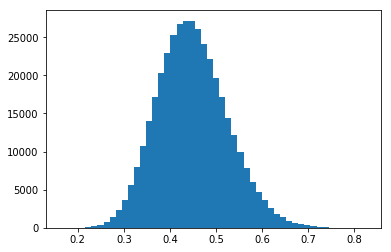

In [24]:
cnt,bins,patches =plt.hist(ms,50)

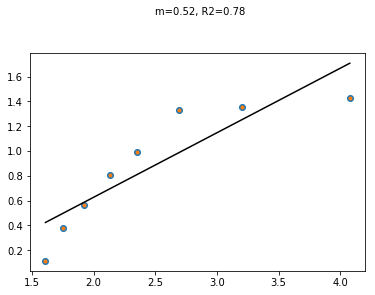

In [33]:
data_idx = 0
plt.plot(np.log(float(t_pts)/window_nums.astype(float)),np.log(N_var_mat[data_idx,:]),'o')
#plt.plot((t_pts/window_nums),(N_var_mat[0,:]),'-o')

plt.plot(np.log(x),y[:,data_idx],'.')
c,m = x_[:,data_idx]
plt.plot(np.log(x),np.log(x)*m+c,'k')
plt.text(2.5,2.1,"m={:0.2f}, R2={:0.2f}".format(m,R2[data_idx]))


In [5]:
############## 
# Do the same thing on our own data, a subset extracted for matlab testing previously
%pylab inline
fname = '/home/chris/Downloads/P05_500_vox_tcourse.txt'
d = np.loadtxt(fname,skiprows=3) #skip the xyz coords, as this was extracted with fslmeants

Populating the interactive namespace from numpy and matplotlib


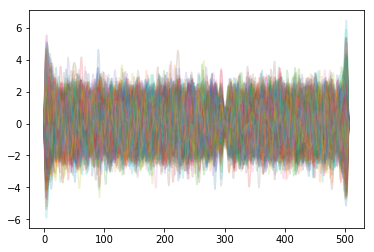

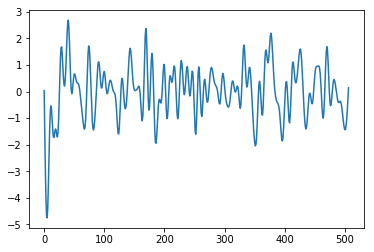

In [6]:
ax = plt.plot(d,alpha=0.2)
plt.figure()
ax = plt.plot(d[:,0])
data_masked = d.T #transpose so that time is in columns, just cause...

In [20]:
verbose = False
order = 2
data_masked_cumsum = np.cumsum(data_masked,axis=1) #cumsum over time
#window this shit
t_pts = data_masked_cumsum.shape[1]
#reverse, so we go from smaller num samples up

window_num = 8
#per window (appx):
min_samples = 5
max_samples = np.floor(t_pts/5.0).astype(int)
window_nums = np.round(np.geomspace(min_samples,max_samples,num=10)).astype(int)[::-1]
window_nums

array([101,  72,  52,  37,  27,  19,  14,  10,   7,   5])

In [143]:
verbose = False
order = 2
data_masked_cumsum = np.cumsum(data_masked,axis=1) #cumsum over time
#window this shit
t_pts = data_masked_cumsum.shape[1]
#reverse, so we go from smaller num samples up

window_num = 8
#per window (appx):
min_samples = 5
max_samples = np.round(t_pts/5.0) #gives us 5 as the lowest number of bins
#window_nums = np.round(np.linspace(np.floor(t_pts/(t_pts/5)).astype(int),np.floor(t_pts/10).astype(int),num=10))[::-1]
window_nums = np.round(np.geomspace(min_samples,max_samples,num=window_num)).astype(int)[::-1]

#window_nums = np.array([5,10,20,30])
print("Number of windows per iteration:")
print(window_nums)
print("\nNumber of data points in each window per iteration (appx):")
print(float(t_pts)/window_nums.astype(float))
N_var_mat = np.zeros((data_masked_cumsum.shape[0],len(window_nums)))

for win_idx,window_num in enumerate(window_nums):
    st = time.time()
    wins = np.array_split(data_masked_cumsum,window_num,axis=1)
    var = np.zeros((data_masked_cumsum.shape[0],len(wins)))
    for idx,win in enumerate(wins):
        #calc variance for detrended window data
        #detrend all windows
        var[:,idx]= np.std(detrend_common(win,order=order)[0],axis=1)**2

    #average over windows
    #save this estimate with window size for plotting later
    N_var_mat[:,win_idx] =np.mean(var,axis=1)
    
    et=time.time()
    if verbose:
        print('Window idx {} with {} windows, appx {} samples per window'.format(win_idx,window_num,(float(t_pts)/float(window_num))))
        print("elapsed: {0:.2f}s".format(et-st))

Number of windows per iteration:
[101  66  43  28  18  12   8   5]

Number of data points in each window per iteration (appx):
[   5.01980198    7.68181818   11.79069767   18.10714286   28.16666667
   42.25         63.375       101.4       ]


In [144]:
## perform the linear regression to extract the slope of the line (Hurst xp) and R2 values (for checking that our estimate is good)
x = (float(t_pts)/window_nums.astype(float))
y = np.log(N_var_mat.T) #so that the data is in columns
X = np.vstack([np.ones(len(x)),np.log(x)]).T
x_, resid, rank, s = np.linalg.lstsq(X,y) #simple linear fit

# checked R2 calc, much faster than with SSresid and SStot
R2 = 1-np.divide(resid,np.multiply(y.shape[0],np.std(y,axis=0)**2)) #https://stackoverflow.com/questions/3054191/converting-numpy-lstsq-residual-value-to-r2
cs,ms = x_ #ms are the slopes/HE

#%timeit pred_y = np.dot(X, x_) #not necessary since we have the resids here
#%timeit SSresid = np.sum(np.power(pred_y-y,2),0) #SSd for each voxel
#%timeit SStot = np.sum(np.power(y-np.mean(y,0),2),axis=0)
#%timeit 1-SSresid/SStot

In [145]:
def element_corrcoef(data_mat1,data_mat2):
    '''
    takes in two even matrices of N (obs) x M (time) and correlates them
    '''
    res_r = np.zeros((data_mat1.shape[0],data_mat1.shape[0]))
    for el_idx in range(0,data_mat1.shape[0]):
        m1 = data_mat2[:el_idx,:]
        m2 = data_mat2[el_idx+1:,:]
        data_submat2 = np.vstack((m1,m2))
        res_r[el_idx,:] = np.corrcoef(data_mat1[el_idx,:],data_submat2)[0,:]
    return res_r
'''
data_mat1 = data_masked
data_mat2 = data_masked
el_idx =0
res =np.corrcoef(data_mat1[0,:],data_mat1[1:,:])
res.shape
plt.imshow(res)
print(np.corrcoef(data_mat1[0,:],data_mat1[1,:]))
#res
res = element_corrcoef(data_mat1,data_mat1)
'''

'\ndata_mat1 = data_masked\ndata_mat2 = data_masked\nel_idx =0\nres =np.corrcoef(data_mat1[0,:],data_mat1[1:,:])\nres.shape\nplt.imshow(res)\nprint(np.corrcoef(data_mat1[0,:],data_mat1[1,:]))\n#res\nres = element_corrcoef(data_mat1,data_mat1)\n'

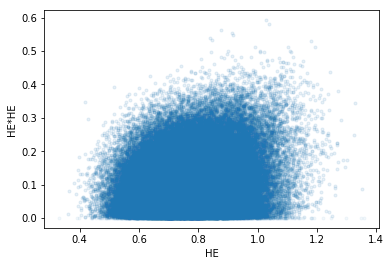

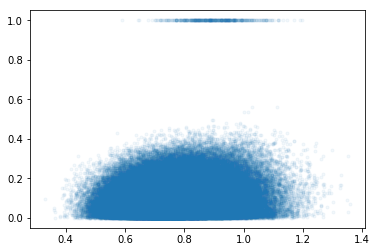

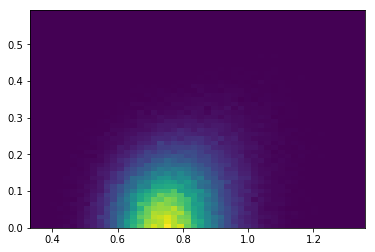

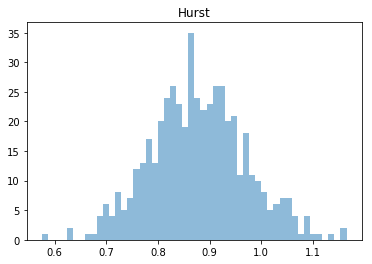

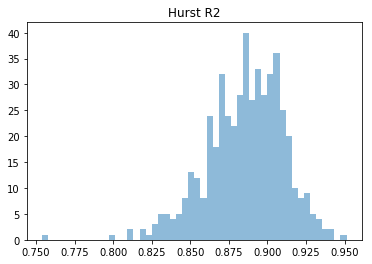

In [146]:
## compute pair-wise correlations of all voxels in data
data_corr = np.corrcoef(data_masked)
#data_corr_null = np.corrcoef(data_masked,np.fliplr(data_masked)) #fliprd to reverse timecourse, time in cols, row are obs
data_corr_null = element_corrcoef(data_masked,np.fliplr(data_masked)) #fliprd to reverse timecourse, time in cols, row are obs

np.fill_diagonal(data_corr,0)
np.max(data_corr,axis=0)
#np.max(data_corr_null,axis=0)
Exp = ms[:,np.newaxis].T*ms[:,np.newaxis] #annoying that it does not work correctly without newaxis...

#plt.plot(ms,np.max(np.abs(data_corr_null),axis=0),'o')
plt.plot(np.ndarray.flatten(Exp),np.ndarray.flatten(np.abs(data_corr)),'.',alpha=0.05)
plt.ylabel('HE*HE')
plt.xlabel('HE')
plt.figure()
plt.plot(np.ndarray.flatten(Exp),np.ndarray.flatten(np.abs(data_corr_null)),'.',alpha=0.05)

plt.figure()
plt.hist2d(np.ndarray.flatten(Exp),np.ndarray.flatten(np.abs(data_corr)),bins=50)

plt.figure()
cnt,bins,patches =plt.hist(ms,50,alpha=0.5)
plt.title('Hurst')
plt.figure()
cnt,bins,patches =plt.hist(R2,50,alpha=0.5)
plt.title('Hurst R2')


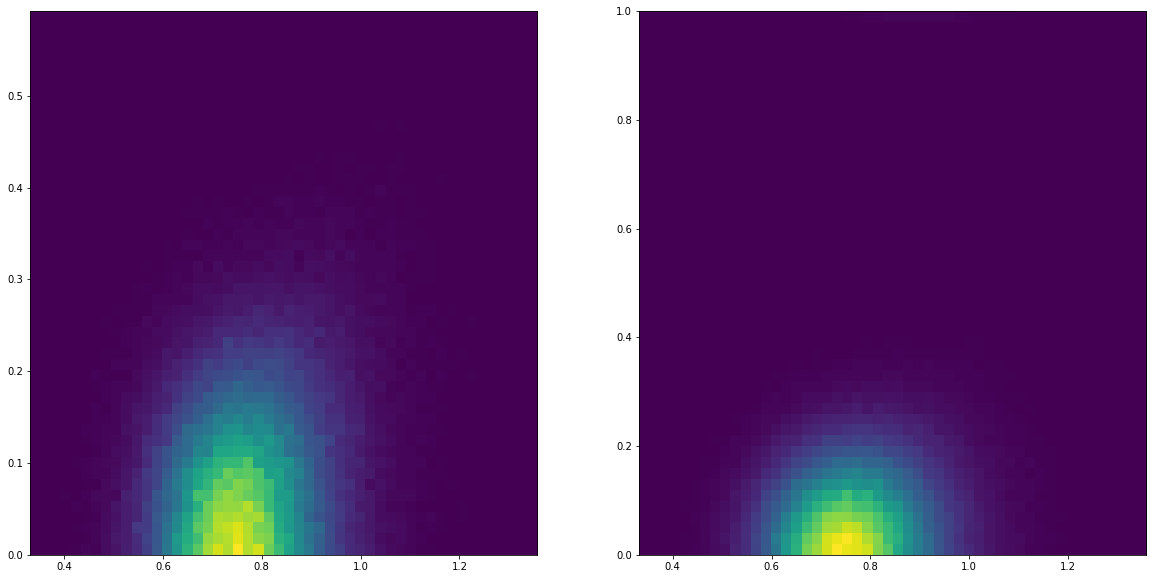

In [147]:
f,ax = plt.subplots(1,2,figsize=(20,10))
p1 = ax[0].hist2d(np.ndarray.flatten(Exp),np.ndarray.flatten(np.abs(data_corr)),bins=50)
p2 = ax[1].hist2d(np.ndarray.flatten(Exp),np.ndarray.flatten(np.abs(data_corr_null)),bins=50)


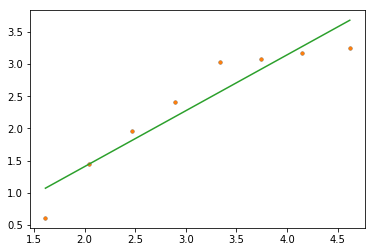

In [148]:
data_idx = 5
plt.plot(np.log(float(t_pts)/window_nums.astype(float)),np.log(N_var_mat[data_idx,:]),'.')
#plt.plot((t_pts/window_nums),(N_var_mat[0,:]),'-o')

plt.plot(np.log(x),y[:,data_idx],'.')
c,m = x_[:,data_idx]
plt.plot(np.log(x),np.log(x)*m+c)